In [1]:
import pandas as pd
import re
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
from torch.utils.data import WeightedRandomSampler
import numpy as np



c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PRE-Traitement

In [2]:
df = pd.read_csv('../../data/data_en_motsclé.csv')
print(f"Dimensions du DataFrame: {df.shape}")
df.head()


Dimensions du DataFrame: (501, 3)


,question,answer,label
0,Do you have a color or style in mind?,I’m looking for a blueprint for a birdhouse.,0
1,What's your usual size?,"I'm not sure, what size is the mannequin wearing?",1
2,Do you have a color or style in mind?,I saw a blue heron at the lake last week.,0
3,Do you like this model?,"To be honest, I don't like the style.",1
4,Do you have a color or style in mind?,"For the color, I'd prefer blue. The style is f...",1


In [3]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.\?,!àâéèêëîïôûùüçÀÂÉÈÊËÎÏÔÛÙÜÇ\']', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_question'] = df['question'].apply(clean_text)
df['cleaned_answer'] = df['answer'].apply(clean_text)


df[['cleaned_question', 'cleaned_answer', 'label']].head()

,cleaned_question,cleaned_answer,label
0,do you have a color or style in mind?,im looking for a blueprint for a birdhouse.,0
1,what's your usual size?,"i'm not sure, what size is the mannequin wearing?",1
2,do you have a color or style in mind?,i saw a blue heron at the lake last week.,0
3,do you like this model?,"to be honest, i don't like the style.",1
4,do you have a color or style in mind?,"for the color, i'd prefer blue. the style is f...",1


### Fonction

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Implémentation de la Focal Loss, une fonction de perte différentiable
    pour l'optimisation du F1-score et du recall dans les
    problèmes de classification déséquilibrés.
    """
    def __init__(self, alpha=None, gamma=2., reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):

        ce_loss = F.cross_entropy(inputs, targets, reduction='none')


        pt = torch.exp(-ce_loss)


        focal_loss = (1 - pt) ** self.gamma * ce_loss


        if self.alpha is not None:
            if self.alpha.device != focal_loss.device:
                self.alpha = self.alpha.to(focal_loss.device)
            
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [5]:

MODEL_NAME = "distilbert-base-uncased" # Or "roberta-base", "bert-base-uncased", on prend distilbert pour la vitesse

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class QACoherenceDataset(Dataset):
    def __init__(self, questions, answers, labels, tokenizer, max_len):
        self.questions = questions
        self.answers = answers
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        answer = str(self.answers[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# --- 4. Fonctions d'Entraînement et d'Évaluation ---

def train_epoch_fn(model, data_loader, criterion, optimizer, scheduler, device, n_examples): # Ajout de criterion
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # Obtenir les logits SANS calculer la perte dans le modèle
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            # On ne passe plus 'labels' ici
        )
        logits = outputs.logits
        
        # Calculer la perte avec notre fonction custom
        loss = criterion(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
    return correct_predictions.double() / n_examples, total_loss / len(data_loader)

def eval_model_fn(model, data_loader, criterion, device, n_examples): # Ajout de criterion
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    all_true_labels = []
    all_pred_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Obtenir les logits
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            
            # Calculer la perte avec la même fonction pour la comparaison
            loss = criterion(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_eval_loss += loss.item()
            
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
            
    avg_loss = total_eval_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    
    return accuracy, avg_loss, all_true_labels, all_pred_labels

# Entrainement

In [7]:
BATCH_SIZE = 8
MAX_LEN = 90

class_weights_sample = [1, 1] # ou [1,2] si on veux pondérer

LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
EPOCHS = 5



In [8]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation du device: {device}")

Utilisation du device: cpu


In [10]:
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

cv_history = []   
all_fold_f1 = []  
all_fold_recall = []  

for fold, (train_idx, val_idx) in enumerate(kf.split(df[['cleaned_question', 'cleaned_answer']], df['label'])):
    print(f"\n=== Fold {fold+1} / {kf.get_n_splits()} ===")

    train_questions = df.iloc[train_idx]['cleaned_question'].values
    train_answers   = df.iloc[train_idx]['cleaned_answer'].values
    train_labels    = df.iloc[train_idx]['label'].values

    val_questions = df.iloc[val_idx]['cleaned_question'].values
    val_answers   = df.iloc[val_idx]['cleaned_answer'].values
    val_labels    = df.iloc[val_idx]['label'].values

    train_dataset = QACoherenceDataset(train_questions, train_answers, train_labels, tokenizer, MAX_LEN)
    val_dataset   = QACoherenceDataset(val_questions, val_answers, val_labels, tokenizer, MAX_LEN)


    class_counts = np.bincount(train_labels)
    sample_weights = np.array([class_weights_sample[label] for label in train_labels])
    sampler = WeightedRandomSampler(weights=torch.from_numpy(sample_weights).double(),
                                    num_samples=len(sample_weights),
                                    replacement=True)
    criterion = FocalLoss(alpha=torch.from_numpy(sample_weights).double(), gamma=2)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)

   
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=int(0.1 * total_steps),
                                                num_training_steps=total_steps)


    # Entraînement
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [],
               'val_acc': [], 'val_f1': [], 'val_recall': []}

    best_val_f1 = 0
    best_val_recall = 0

    for epoch in range(EPOCHS):
        train_acc, train_loss = train_epoch_fn(model, train_loader, criterion, optimizer, scheduler, device, len(train_dataset))
        val_acc, val_loss, val_true, val_pred = eval_model_fn(model, val_loader, criterion, device, len(val_dataset))

        val_f1 = f1_score(val_true, val_pred, pos_label=1)
        val_recall = recall_score(val_true, val_pred, pos_label=1)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc.item())
        history['val_acc'].append(val_acc.item())
        history['val_f1'].append(val_f1)
        history['val_recall'].append(val_recall)

        print(f"Epoch {epoch+1}: Train acc {train_acc:.3f}, "
              f"Val acc {val_acc:.3f}, Val Recall {val_recall:.3f}, Val F1 {val_f1:.3f}")

        save_condition = (val_f1 > best_val_f1) or \
                        (val_f1 == best_val_f1 and val_recall > best_val_recall)

        if save_condition:
            best_val_recall = val_recall
            best_val_f1 = val_f1

    cv_history.append(history)
    all_fold_f1.append(best_val_f1)
    all_fold_recall.append(best_val_recall)



=== Fold 1 / 5 ===


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train acc 0.685, Val acc 0.802, Val Recall 0.694, Val F1 0.773
Epoch 2: Train acc 0.958, Val acc 0.851, Val Recall 0.755, Val F1 0.831
Epoch 3: Train acc 0.958, Val acc 0.911, Val Recall 0.878, Val F1 0.905
Epoch 4: Train acc 0.995, Val acc 0.911, Val Recall 0.939, Val F1 0.911
Epoch 5: Train acc 0.993, Val acc 0.911, Val Recall 0.878, Val F1 0.905

=== Fold 2 / 5 ===


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train acc 0.666, Val acc 0.910, Val Recall 0.938, Val F1 0.909
Epoch 2: Train acc 0.935, Val acc 0.970, Val Recall 0.979, Val F1 0.969
Epoch 3: Train acc 0.985, Val acc 0.940, Val Recall 0.958, Val F1 0.939
Epoch 4: Train acc 0.983, Val acc 0.960, Val Recall 1.000, Val F1 0.960
Epoch 5: Train acc 0.993, Val acc 0.950, Val Recall 1.000, Val F1 0.950

=== Fold 3 / 5 ===


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train acc 0.658, Val acc 0.850, Val Recall 0.875, Val F1 0.848
Epoch 2: Train acc 0.905, Val acc 0.950, Val Recall 0.938, Val F1 0.947
Epoch 3: Train acc 0.983, Val acc 0.940, Val Recall 0.979, Val F1 0.940
Epoch 4: Train acc 0.975, Val acc 0.930, Val Recall 0.979, Val F1 0.931


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 5: Train acc 0.988, Val acc 0.940, Val Recall 0.979, Val F1 0.940

=== Fold 4 / 5 ===
Epoch 1: Train acc 0.676, Val acc 0.910, Val Recall 0.837, Val F1 0.901
Epoch 2: Train acc 0.955, Val acc 0.950, Val Recall 1.000, Val F1 0.951
Epoch 3: Train acc 0.985, Val acc 0.940, Val Recall 0.980, Val F1 0.941
Epoch 4: Train acc 0.990, Val acc 0.950, Val Recall 0.980, Val F1 0.950


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 5: Train acc 0.990, Val acc 0.940, Val Recall 0.980, Val F1 0.941

=== Fold 5 / 5 ===
Epoch 1: Train acc 0.668, Val acc 0.760, Val Recall 1.000, Val F1 0.803
Epoch 2: Train acc 0.915, Val acc 0.950, Val Recall 0.980, Val F1 0.950
Epoch 3: Train acc 0.970, Val acc 0.950, Val Recall 1.000, Val F1 0.951
Epoch 4: Train acc 0.988, Val acc 0.950, Val Recall 0.980, Val F1 0.950
Epoch 5: Train acc 0.993, Val acc 0.960, Val Recall 0.980, Val F1 0.960


In [11]:
print(f'F1-score : {np.mean(all_fold_f1)}, Recall : {np.mean(all_fold_recall)}')

F1-score : 0.9477575971579215, Recall : 0.9670068027210885


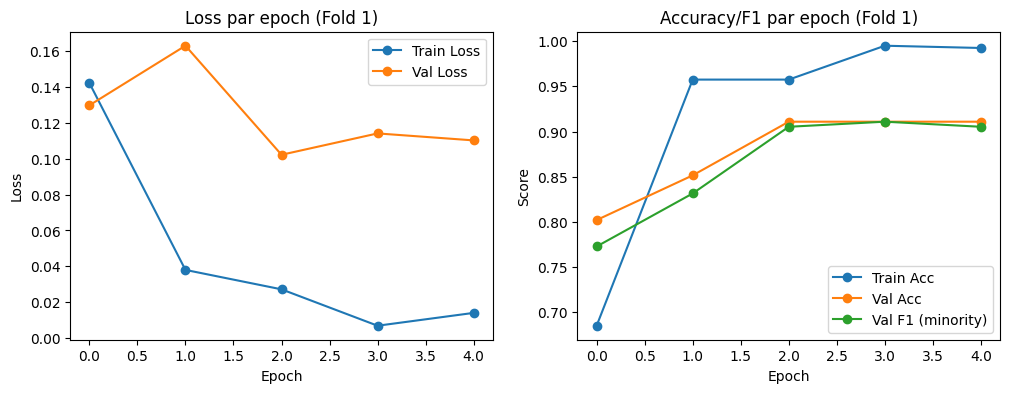

In [12]:
fold0 = cv_history[0]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fold0['train_loss'], 'o-',label="Train Loss")
plt.plot(fold0['val_loss'], 'o-',label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss par epoch (Fold 1)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(fold0['train_acc'], 'o-',label="Train Acc")
plt.plot(fold0['val_acc'], 'o-',label="Val Acc")
plt.plot(fold0['val_f1'], 'o-',label="Val F1 (minority)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy/F1 par epoch (Fold 1)")
plt.legend()
plt.show()

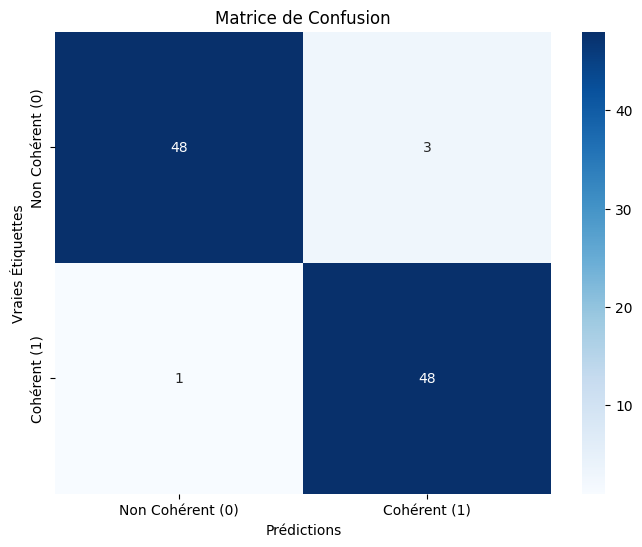

In [13]:

final_test_acc, final_test_loss, true_labels, pred_labels = eval_model_fn(model, val_loader, criterion, device, len(val_dataset))


cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cohérent (0)', 'Cohérent (1)'], yticklabels=['Non Cohérent (0)', 'Cohérent (1)'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.title('Matrice de Confusion')
plt.show()



In [14]:
decoded_texts = [tokenizer.decode(item['input_ids'], skip_special_tokens=True) for item in val_dataset]

df_results = pd.DataFrame({
    'decoded_input': decoded_texts,
    'true_label': true_labels,
    'pred_label': pred_labels
})

##########"" Afficher toutes les lignes 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
##########################

false_positives = df_results[(df_results['true_label'] == 0) & (df_results['pred_label'] == 1)]
false_negatives = df_results[(df_results['true_label'] == 1) & (df_results['pred_label'] == 0)]

print("FAUX POSITIFS :") 
print(false_positives[['decoded_input']])

print("\nFAUX NÉGATIFS :")
print(false_negatives[['decoded_input']].head())


FAUX POSITIFS :
                                                                                                     decoded_input
2                                           what's your usual size? i'm looking for a size that doesn't exist yet.
14  would you like to try something else or go to checkout? what time is the hotel checkout? i'm not staying here.
59                                               what's a your usual size? i don't believe in the concept of size.

FAUX NÉGATIFS :
                                   decoded_input
79  what's your usual size? my shoe size is a 9.


# Sauvegarde et Réutilisation

In [15]:
MODEL_SAVE_PATH = "save_model/distilbert_coherence_final_model.bin"
TOKENIZER_SAVE_PATH = "save_model/distilbert_coherence_tokenizer/"


model.to(device)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
tokenizer.save_pretrained(TOKENIZER_SAVE_PATH)

('save_model/distilbert_coherence_tokenizer/tokenizer_config.json',
 'save_model/distilbert_coherence_tokenizer/special_tokens_map.json',
 'save_model/distilbert_coherence_tokenizer/vocab.txt',
 'save_model/distilbert_coherence_tokenizer/added_tokens.json',
 'save_model/distilbert_coherence_tokenizer/tokenizer.json')

In [ ]:
MODEL_NAME_FOR_TEST = "distilbert-base-uncased" 
MODEL_SAVE_PATH_FOR_LOAD = "save_model/distilbert_coherence_final_model.bin"
TOKENIZER_SAVE_PATH_FOR_LOAD = "save_model/distilbert_coherence_tokenizer/"


MAX_LEN_FOR_TEST = 90
DEVICE_FOR_TEST = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def clean_text_for_prediction(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.\?,!àâéèêëîïôûùüçÀÂÉÈÊËÎÏÔÛÙÜÇ\']', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text


model_to_test = None
tokenizer_to_test = None
device_to_test = None
max_len_to_test = None
clean_text_func_to_use = None


tokenizer_to_test = AutoTokenizer.from_pretrained(TOKENIZER_SAVE_PATH_FOR_LOAD)


model_to_test = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_FOR_TEST, num_labels=2)

# Charger les poids sauvegardés
model_to_test.load_state_dict(torch.load(MODEL_SAVE_PATH_FOR_LOAD, map_location=DEVICE_FOR_TEST))
model_to_test.to(DEVICE_FOR_TEST)
model_to_test.eval() 

max_len_to_test = MAX_LEN_FOR_TEST 
clean_text_func_to_use = clean_text_for_prediction
device_to_test = DEVICE_FOR_TEST 

c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def predict_coherence(question, answer, model, tokenizer, device, max_len, clean_fn):

    cleaned_question = clean_fn(question)
    cleaned_answer = clean_fn(answer)

    encoding = tokenizer.encode_plus(
        cleaned_question,
        cleaned_answer,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction_idx = torch.argmax(probs, dim=1).cpu().item()
        probability_score = probs[0][prediction_idx].cpu().item()

    return prediction_idx, probability_score

In [23]:

test_samples = [
{
    "question": "Hello, what can I do for you today?",
    "answer": "I am looking for a red T-shirt."
},  # Coherent
{
    "question": "Hello, what can I do for you today?",
    "answer": "I am looking at the sky for a spaceship." 
},  # Incoherent
{
    "question": "What is your usual size?",
    "answer": "My usual size is medium."
},  # Coherent
{
    "question": "What is your usual size?",
    "answer": "My usual size is a big elephant."
},  # Incoherent
{
    "question": "Do you have a color or style in mind?",
    "answer": "Yes, I am looking for a blue jacket."
},  # Coherent
{
    "question": "Do you have a color or style in mind?",
    "answer": "blue"
},  # Incoherent
{
    "question": "Do you like this model?",
    "answer": "Yes, I like this model. It looks nice."
},  # Coherent
{
    "question": "Do you like this model?",
    "answer": "Yes, I like eating pizza at night."
},  # Incoherent
{
    "question": "Would you like to try something else or go to checkout?",
    "answer": "I want to go to checkout now."
},  # Coherent
{
    "question": "Would you like to try something else or go to checkout?",
    "answer": "I want to checkout the moon tonight."
},  # Incoherent
]

In [24]:


for i, sample in enumerate(test_samples):
    q = sample["question"]
    a = sample["answer"]

    print(f"\nExemple {i+1}:")
    print(f"  Question: \"{q}\"")
    print(f"  Réponse:  \"{a}\"")

    pred_label, pred_prob = predict_coherence(q, a,
                                                model_to_test,
                                                tokenizer_to_test,
                                                device_to_test,
                                                max_len_to_test,
                                                clean_text_func_to_use)


    coherence_status = "Cohérent" if pred_label == 1 else "Non Cohérent"
    print(f"  Prédiction: {coherence_status} (Label: {pred_label}, Confiance: {pred_prob:.4f})")



Exemple 1:
  Question: "Hello, what can I do for you today?"
  Réponse:  "I am looking for a red T-shirt."
  Prédiction: Cohérent (Label: 1, Confiance: 0.9343)

Exemple 2:
  Question: "Hello, what can I do for you today?"
  Réponse:  "I am looking at the sky for a spaceship."
  Prédiction: Non Cohérent (Label: 0, Confiance: 0.8763)

Exemple 3:
  Question: "What is your usual size?"
  Réponse:  "My usual size is medium."
  Prédiction: Cohérent (Label: 1, Confiance: 0.7805)

Exemple 4:
  Question: "What is your usual size?"
  Réponse:  "My usual size is a big elephant."
  Prédiction: Non Cohérent (Label: 0, Confiance: 0.9483)

Exemple 5:
  Question: "Do you have a color or style in mind?"
  Réponse:  "Yes, I am looking for a blue jacket."
  Prédiction: Cohérent (Label: 1, Confiance: 0.9429)

Exemple 6:
  Question: "Do you have a color or style in mind?"
  Réponse:  "blue"
  Prédiction: Non Cohérent (Label: 0, Confiance: 0.9167)

Exemple 7:
  Question: "Do you like this model?"
  Réponse